## RNN model for spatiotemporal predictions

Using a Recurrent Neural Network here, i want to take into account both <b>spatial</b> and <b>temporal</b> contributions to let the model identify patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_input = pd.read_csv(r'C:\Users\alexi\training_input_lat8cht.csv',dtype=np.float64)
data_output = pd.read_csv(r'C:\Users\alexi\training_output_Z18GQCh.csv',dtype=np.float64)

## Data preprocessing 

Here i want to preprocess the dataset and reshape it into a 3D tensor (num_samples, times_steps, features).<br>
What is the good shape for LSTM input.

In [4]:
# Feature engineering, using pandas library

def preprocess(data):
    
    data.loc[:, 'value_0' : 'value_9'].fillna(value=1,inplace=True)
    data.loc[:, 'distance_0' : 'distance_9'].fillna(value=1000000,inplace=True)
    
    data.loc[:,'int'] = 0
    
    X = data.loc[:, 'hdres_100' : 'major_roads_length_500']
    X.loc[:,'sum'] = 0
    
    for i in range(9):
        data.loc[:,'intensity_{}'.format(i)] = (data.loc[:,'value_{}'.format(i)]
                                                   /data.loc[:,'distance_{}'.format(i)]
                                                   /data.loc[:,'distance_{}'.format(i)])
     
        data.loc[:,'int_{}'.format(i)] = np.heaviside(data.loc[:,'intensity_{}'.format(i)], 0.01)
        
        X.loc[:,'sum'] = X.loc[:,'sum'] + data.loc[:,'intensity_{}'.format(i)]
        data.loc[:,'int'] = data.loc[:,'int'] + data.loc[:,'int_{}'.format(i)]

    X.loc[:,'sum'] = X.loc[:,'sum'] / data.loc[:,'int']
    
    # Normalize the columns between [0,1]
    max_sum = X['sum'].max()
    min_sum = X['sum'].min()
    X['sum'] = X['sum'].apply(lambda x: (x - min_sum) / (max_sum - min_sum))
    
    X = pd.concat([data['station_id'],X],axis=1)
        
    return X

In [5]:
# Reshape preprocessed data into (num_samples, times_steps, features), using numpy library

def reshape_data(data,c):
    
    a = data['station_id'].nunique()
    b = 8779
    #c = len(data.columns)
    #c=15
    data=data.values
    
    y=0
    z=0
    
    X = np.zeros([a,b,c])

    for i in range(len(data)-1):
        X[z,y,:] = data[i,1:]
        if data[i,0].astype(int) == data[i+1,0].astype(int):
            y=y+1
        else:
            y=0
            z=z+1
            
    return X            

In [6]:
data_preprocessed = preprocess(data_input)
data_preprocessed = pd.concat([data_preprocessed,data_output['value']],axis=1)
reshaped_data = reshape_data(data_preprocessed,16)
print('Data shape : ', reshaped_data.shape)

Data shape :  (85, 8779, 16)


In [7]:
X_train = reshaped_data[:70,:,:15]
X_test = reshaped_data[70:,:,:15]
y_train = reshaped_data[:70,:,15]
y_test = reshaped_data[70:,:,15]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

## RNN model

<b>Principle :</b> $RNN$ is like a wrap feedforward NN. Some signals are going back in the NN, so it keeps information about previous time steps to understand the current state. $RNN$ is usefull with strong local correlation in time, but not global.<br>
$LSTM$ cell (Long Short Time Memory) has the advantage to delete backpropagation signals to avoid too long dependency between signals.<br>

Main hyperparameters :

- Number of epochs : dataset entirely passed through learning
- Batch size : size of subsets used for learning
- Number of neurons (in LSTM layer)

In [8]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import adam
from keras import losses

import tensorflow as tf
from tensorflow.contrib.rnn import *

model = Sequential()
model.add(LSTM(15, 
               input_shape=(X_train.shape[1],X_train.shape[2]), 
               return_sequences=True))
model.add(Dense(1))
model.compile(loss=losses.mean_squared_logarithmic_error, optimizer='adam')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# fit network
history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_data=(X_test, y_test), 
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 70 samples, validate on 15 samples
Epoch 1/500
 - 20s - loss: 8.3567 - val_loss: 9.1007
Epoch 2/500
 - 22s - loss: 8.2688 - val_loss: 8.8943
Epoch 3/500
 - 24s - loss: 8.0299 - val_loss: 8.5929
Epoch 4/500
 - 25s - loss: 7.6940 - val_loss: 8.2592
Epoch 5/500
 - 25s - loss: 7.3379 - val_loss: 7.9071
Epoch 6/500
 - 25s - loss: 6.9843 - val_loss: 7.5748
Epoch 7/500
 - 24s - loss: 6.6279 - val_loss: 7.2478
Epoch 8/500
 - 25s - loss: 6.2968 - val_loss: 6.9324
Epoch 9/500
 - 25s - loss: 5.9854 - val_loss: 6.6375
Epoch 10/500
 - 25s - loss: 5.7076 - val_loss: 6.3611
Epoch 11/500
 - 24s - loss: 5.4526 - val_loss: 6.1044
Epoch 12/500
 - 25s - loss: 5.2256 - val_loss: 5.8660
Epoch 13/500
 - 25s - loss: 5.0164 - val_loss: 5.6481
Epoch 14/500
 - 28s - loss: 4.8264 - val_loss: 5.4437
Epoch 15/500
 - 26s - loss: 4.6557 - val_loss: 5.2506
Epoch 16/500
 - 26s - loss: 4.4959 - val_loss: 5.0710
Epoch 17/500
 - 25s - loss: 4.3467 - val_loss: 4.9007

Epoch 147/500
 - 21s - loss: 0.9534 - val_loss: 1.1695
Epoch 148/500
 - 22s - loss: 0.9486 - val_loss: 1.1661
Epoch 149/500
 - 19s - loss: 0.9442 - val_loss: 1.1621
Epoch 150/500
 - 19s - loss: 0.9396 - val_loss: 1.1577
Epoch 151/500
 - 19s - loss: 0.9354 - val_loss: 1.1528
Epoch 152/500
 - 17s - loss: 0.9313 - val_loss: 1.1478
Epoch 153/500
 - 17s - loss: 0.9270 - val_loss: 1.1427
Epoch 154/500
 - 17s - loss: 0.9228 - val_loss: 1.1375
Epoch 155/500
 - 17s - loss: 0.9186 - val_loss: 1.1323
Epoch 156/500
 - 17s - loss: 0.9146 - val_loss: 1.1270
Epoch 157/500
 - 17s - loss: 0.9106 - val_loss: 1.1218
Epoch 158/500
 - 17s - loss: 0.9054 - val_loss: 1.1166
Epoch 159/500
 - 17s - loss: 0.8989 - val_loss: 1.1026
Epoch 160/500
 - 17s - loss: 0.8952 - val_loss: 1.0979
Epoch 161/500
 - 17s - loss: 0.8915 - val_loss: 1.0933
Epoch 162/500
 - 17s - loss: 0.8880 - val_loss: 1.0888
Epoch 163/500
 - 17s - loss: 0.8845 - val_loss: 1.0842
Epoch 164/500
 - 17s - loss: 0.8809 - val_loss: 1.0797
Epoch 165/

Epoch 296/500
 - 18s - loss: 0.6062 - val_loss: 0.7470
Epoch 297/500
 - 19s - loss: 0.6050 - val_loss: 0.7456
Epoch 298/500
 - 21s - loss: 0.6039 - val_loss: 0.7442
Epoch 299/500
 - 20s - loss: 0.6027 - val_loss: 0.7428
Epoch 300/500
 - 21s - loss: 0.6016 - val_loss: 0.7415
Epoch 301/500
 - 19s - loss: 0.6005 - val_loss: 0.7401
Epoch 302/500
 - 20s - loss: 0.5995 - val_loss: 0.7388
Epoch 303/500
 - 19s - loss: 0.5984 - val_loss: 0.7375
Epoch 304/500
 - 18s - loss: 0.5973 - val_loss: 0.7362
Epoch 305/500
 - 19s - loss: 0.5962 - val_loss: 0.7348
Epoch 306/500
 - 19s - loss: 0.5951 - val_loss: 0.7335
Epoch 307/500
 - 18s - loss: 0.5940 - val_loss: 0.7322
Epoch 308/500
 - 17s - loss: 0.5930 - val_loss: 0.7309
Epoch 309/500
 - 18s - loss: 0.5919 - val_loss: 0.7296
Epoch 310/500
 - 19s - loss: 0.5908 - val_loss: 0.7282
Epoch 311/500
 - 20s - loss: 0.5897 - val_loss: 0.7269
Epoch 312/500
 - 19s - loss: 0.5887 - val_loss: 0.7257
Epoch 313/500
 - 17s - loss: 0.5876 - val_loss: 0.7244
Epoch 314/

Epoch 445/500
 - 17s - loss: 0.4872 - val_loss: 0.5803
Epoch 446/500
 - 18s - loss: 0.4866 - val_loss: 0.5796
Epoch 447/500
 - 17s - loss: 0.4861 - val_loss: 0.5789
Epoch 448/500
 - 17s - loss: 0.4856 - val_loss: 0.5783
Epoch 449/500
 - 18s - loss: 0.4851 - val_loss: 0.5777
Epoch 450/500
 - 17s - loss: 0.4846 - val_loss: 0.5770
Epoch 451/500
 - 17s - loss: 0.4841 - val_loss: 0.5764
Epoch 452/500
 - 17s - loss: 0.4836 - val_loss: 0.5758
Epoch 453/500
 - 17s - loss: 0.4831 - val_loss: 0.5751
Epoch 454/500
 - 17s - loss: 0.4826 - val_loss: 0.5745
Epoch 455/500
 - 18s - loss: 0.4821 - val_loss: 0.5739
Epoch 456/500
 - 18s - loss: 0.4816 - val_loss: 0.5733
Epoch 457/500
 - 19s - loss: 0.4811 - val_loss: 0.5727
Epoch 458/500
 - 19s - loss: 0.4806 - val_loss: 0.5721
Epoch 459/500
 - 19s - loss: 0.4802 - val_loss: 0.5715
Epoch 460/500
 - 19s - loss: 0.4797 - val_loss: 0.5709
Epoch 461/500
 - 17s - loss: 0.4792 - val_loss: 0.5704
Epoch 462/500
 - 19s - loss: 0.4787 - val_loss: 0.5698
Epoch 463/

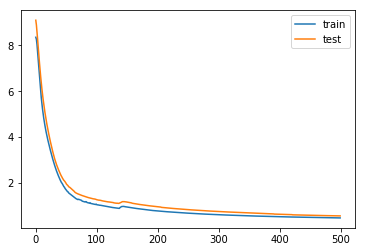

In [10]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Submission

In [11]:
submission = pd.read_csv(r'C:\Users\alexi\testing_input_A9o5RSM.csv',dtype=np.float64)

In [12]:
# Preprocess and Reshape file into (stations, times_steps, features) 

submission_pre = preprocess(submission)
X_sub = reshape_data(submission_pre,15)
print('Data shape : ', X_sub.shape)

Data shape :  (31, 8779, 15)


In [13]:
# Use trained model for prediction

y_sub = model.predict(X_sub)

In [14]:
# Reshape for submission into (stations*times_steps, 1)

shapes = submission['station_id'].value_counts()
shapes = shapes.values
y_sub = y_sub.reshape((31,8779))
i=0
sub = np.zeros(submission.shape[0])

for x in range(y_sub.shape[0]):
    for y in range(shapes[x]):
        sub[i] = y_sub[x,y]
        i=i+1

In [15]:
pd.DataFrame(sub).to_csv('submission_ENS_1.csv')

## Conclusion
